In [2]:
# import dependencies

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
import random
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly

In [3]:
# grab our data from the csv file
df = pd.read_csv('CO2_emissions.csv')
df.shape

(20841, 11)

In [4]:
# To get an idea for which countries we should forecast, lets sort the countries in descending order with highest emission
# totals for the year 2020 since it's the most recent

df[df['year']==2020].sort_values(['co2'], ascending=False)[:10]

,iso_code,country,year,co2,co2_per_capita,co2_growth_prct,co2_growth_abs,cumulative_co2,share_global_co2,share_global_cumulative_co2,population
4061,CHN,China,2020,10667.887,7.412,1.70,177.899,235564.013,30.65,13.89,1.439324e+09
20024,USA,United States,2020,4712.771,14.238,-10.33,-543.046,416723.089,13.54,24.56,3.310026e+08
8747,IND,India,2020,2441.792,1.769,-7.01,-184.176,54416.489,7.02,3.21,1.380004e+09
15368,RUS,Russia,2020,1577.136,10.807,-6.09,-102.313,115344.150,4.53,6.80,1.459345e+08
9669,JPN,Japan,2020,1030.775,8.150,-6.80,-75.154,65625.167,2.96,3.87,1.264765e+08
8990,IRN,Iran,2020,745.035,8.870,1.59,11.669,18914.439,2.14,1.11,8.399295e+07
7397,DEU,Germany,2020,644.310,7.690,-9.43,-67.117,92635.615,1.85,5.46,8.378394e+07
15957,SAU,Saudi Arabia,2020,625.508,17.967,0.50,3.095,15936.377,1.80,0.94,3.481387e+07
17114,KOR,South Korea,2020,597.605,11.656,-7.78,-50.420,18335.707,1.72,1.08,5.126918e+07
8879,IDN,Indonesia,2020,589.500,2.155,-10.76,-71.094,14399.960,1.69,0.85,2.735236e+08


In [5]:
# Create a list to store the countries we will forecast from 2020 until 2050. Here we are simply taking the countries with 
# the highest total CO2 emissions for the year 2020 since they will likely be the largest influences in future CO2 emissions
country_list = list(df[df['year']==2020].sort_values(['co2'], ascending=False)[:10].country)
country_list

['China',
 'United States',
 'India',
 'Russia',
 'Japan',
 'Iran',
 'Germany',
 'Saudi Arabia',
 'South Korea',
 'Indonesia']

In [8]:
# function to get the difference order for the ARIMA-model

# get_difference_order('str')
def get_difference_order(country):
    
    # create new dataframe based on the one imported above and select only the data where country is equal to what
    # is entered into the function (this must be a string). Grab what is relevent (year, co2), reset the index to the year,
    df_n = df[df['country']== country]
    df_n = pd.DataFrame(df_n[['year', 'co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # used to get test statistics of our dataset. Here, result[1] is the p-value statistic. We don't want this to be too high
    # or too low (extremely low p-values actually produce more errors long term in our ARIMA model)
    result = adfuller(df_n)
    p_value = result[1]
    
    # set the difference order to 0
    d=0
    
    # while the p-value from above is greater than the upper threshold, iterate
    while p_value > 0.05:
        
        # take a difference and drop the null values
        df_n = df_n.diff().dropna()
        
        # re-evaluate our p-value after differencing using Dicky-Fuller test like before (adfuller())
        result = adfuller(df_n)
        p_value = result[1]
        
        
        # if the new p-value is below the bottom threshold, break the while loop
        if p_value <5e-7:
            break
        
        # else, add +1 to our difference order
        else:
            d+=1
    
    # return the difference order
    return(d)

In [9]:
# create a function to find the optimal amount of autoregressive terms (p)

# get_autogregressive_terms('str')
def get_autoregressive_terms(country):
    
    # set an array of ar_terms to iterate through (here the max p value is 20)
    ar_terms = list(range(0,21))
    # AIC is a measure of how well fit the ARIMA model is. This is a list that we will use to find the p value that
    # minimizes this metric
    aic_values = []
    
    # get our difference order that was defined previously 
    d = get_difference_order(country)
    # simply set q (moving average terms) to 1 for now. We will adjust later by optimizing the choice for this as well
    q = 1
    
    # reassign our new dataframe just like before
    df_n = df[df['country'] == country]
    df_n = pd.DataFrame(df_n[['year','co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # iterate through our possible ar_terms, here we set the maximum number as 20 for computational sake
    for p in range(len(ar_terms)):
        # ignore warnings when fitting the model, otherwise it will clutter the output every iteration
        warnings.filterwarnings("ignore")
        #define the model and specify the order (p,d,q)
        model = ARIMA(df_n, order=(p,d,q))
        # fit the model to the data in our dataframe
        model_fit = model.fit()
        # grab the AIC value associated with the current p value and store it in the respective list of AIC values
        aic_values.append(model_fit.aic)
    
    # grab the minimum aic_value in our list of AIC values
    min_aic = min(aic_values)
    # since each index coincides with the p value (index[2]==p[2]) we can grab the index where the AIC value is the lowest
    # and use that same index for p
    p = ar_terms[aic_values.index(min_aic)]
    
    # return our autoregressive term order for use in other functions
    return(p)

In [10]:
# create a function to find the optimal amount of moving average terms (q)

# get_moving_avg_terms('str')
def get_moving_avg_terms(country):
    
    # make a range of moving average terms from 1-10 (typically this value will never exceed ~3, but just to be safe)
    ma_terms = list(range(1,10))
    aic_values = []
    
    # get our autoregressive_terms and difference_order
    p = get_autoregressive_terms(country)
    d = get_difference_order(country)
    
    # reassign our new dataframe just like before
    df_n = df[df['country'] == country]
    df_n = pd.DataFrame(df_n[['year','co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # iterate through our possible ar_terms, here we set the maximum number as 20 for computational sake
    for q in range(len(ma_terms)):
        
        # same logic as in get_autoregressive_terms()
        warnings.filterwarnings("ignore")
        model = ARIMA(df_n, order=(p,d,q))
        model_fit = model.fit()
        aic_values.append(model_fit.aic)
    
    # same logic as in get_autoregressive_terms() 
    min_aic = min(aic_values)
    q = ma_terms[aic_values.index(min_aic)]
    
    return(q)

In [13]:
# This function is to test how well our model can predict the next value in our dataset. We are using a recursive ARIMA model
# where the model makes it's prediction based on the history of past values, stores the prediction, adds the actual value 
# to the historical data, then refits the model and makes another prediction, etc. This effort makes the model a little more
# robust and able to predict more accurately as it iterates more.

# arima_test('str')
def arima_test(country):
    
    # Call our p,d,q from the previously defined functions that minimize AIC values
    p = get_autoregressive_terms(country)
    d = get_difference_order(country)
    q = get_moving_avg_terms(country)
    
    # reassign our new dataframe just like before
    df_n = df[df['country'] == country]
    df_n = pd.DataFrame(df_n[['year','co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # our CO2 emissions
    X = df_n.values
    
    # selecting a testing size (70% train, 30% test)
    size = int(len(X)*.75)
    
    # slices our original data into train,test sets
    train, test = X[0:size], X[size:len(X)]
    
    # stores our past values, initialized to hold the training set
    history = [x for x in train]
    
    # list to hold our model's predictions
    predictions = list()
    
    # iterate through our test data
    for t in range(len(test)):
    
        warnings.filterwarnings("ignore")

        # Fit the model to our initialzied data (training set) using (p,d,q) from the analysis above
        model = ARIMA(history, order=(p,d,q))

        # Fit the model
        model_fit = model.fit()

        # predict the next value based on the fitted model.
        output = model_fit.forecast()
        yhat = output[0]

        # add the prediction to our list of predictions
        predictions.append(yhat)
        
        obs = test[t]
        history.append(obs)
        
    # calculate our root mean squared error   
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    # a plot to visualize our ARIMA model vs. Actual for our test subset of the data
    x = df_n.index[-len(test):].values
    plt.figure(figsize=(10,6),dpi=100)
    plt.plot(x, test, label='Actual')
    plt.plot(x,predictions, color='r', linestyle='--',label='ARIMA model')
    plt.title(f'Model Predictions vs Test ({country})')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    plt.grid()
    plt.show()
    # Show the RMSE to get an idea of how the model performs
    print("RMSE: %.3f" % rmse)

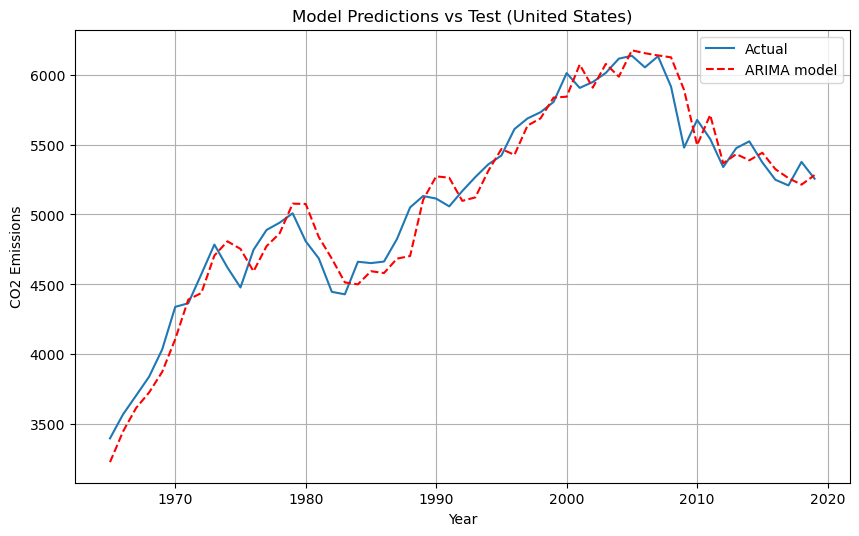

RMSE: 149.324


In [14]:
arima_test('United States')

In [73]:
# set up a DataFrame for forecasted values
forecast_df = pd.DataFrame()

In [74]:
# Define a function to forecast values. The methodology is mostly the same as the arima_test() function, with the addition
# of residuals (bias) to help correct the model's predictive ability (without incorporating this bias the model will likely
# try to plot linearly and sometimes quadratic 2nd order, which doesn't accurately capture the trends we are used to seeing)
def arima_forecast(country, forecast):
    
    # Call our p,d,q from the previously defined functions that minimize AIC values
    p = get_autoregressive_terms(country)
    d = get_difference_order(country)
    q = get_moving_avg_terms(country)
    
    
    # reassign our new dataframe just like before
    df_n = df[df['country'] == country]
    df_n = pd.DataFrame(df_n[['year','co2']])
    # removed 2020 since emissions were historically skewed due to COVID and confuses the model
    df_n = df_n[df_n['year']!=2020]
    df_n = df_n.set_index(['year'])
    df_n = df_n.rename_axis(None, axis=1)
    
    # Same logic as in arima_test() except we are fitting the model to the entire set of historical data so we can forecast
    # years into the future
    history = df_n.values
    predictions = list()
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    
    # grab the residuals (error) from the fit model using model_fit.resid. Store the mean and std to be used in our model's
    # bias adjustment. Our residuals are normally distributed from the fit model, therefore the bias for future predictions
    # should represent a normal distribution which is the motivation of sampling normal random variables with mean = mu and 
    # standard deviation = std. This offers some variability in our predictions to attempt to get closer to modeling how CO2
    # emissions will proceed in the future. 
    
    residuals = pd.DataFrame(model_fit.resid)
    mu = residuals.describe()[0][1]
    std = residuals.describe()[0][2]
    bias = np.random.normal(mu,std,forecast)
    
    # same logic as in arima_test()
    for t in range(forecast):
        warnings.filterwarnings('ignore')
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        
        # this is where we incorporate the bias from the residuals of the fit model above. There is some choice in this as 
        # well. We could generate a larger amount of normally distributed variables and then sample a subset of the larger
        # sample, but I'm not sure if this will help the model in a significant way
        yhat = model_fit.forecast()[0] + bias[t]
        predictions.append(yhat)
        history = np.append(history,yhat)
    
    # grab the previous 30 years before forecasting, and the years that were forecasted as a list. This should be 1990-2050
    years = list(range(df_n.index[-forecast],df_n.index[-1]+forecast+1))
    # grab the co2 values 30 years before forecasting, and the years that were forecasted as a list
    emissions = history[-forecast*2:]
    
    # add the country as a columns to the existing DataFrame where we set the years as the index, columns are countries,
    # values are the co2 emissions (historical and forecasted)
    forecast_df[country] = pd.DataFrame(emissions, index=years)

In [75]:
# iterate through the country_list at the top of this notebook (top 10 countries for co2 emissions in 2020) and perform
# the arima_forecast() function on each country for the next 31 years (the choice for 31 was because we dropped 2020 from 
# the dataset since it skews the model due to historically low emissions for a lot of countries so we need to simulate
# what the expected value would have been if there weren't extenuating circumstances)


for country in country_list:
    arima_forecast(country, 31)

In [ ]:
# For some reason the original export of the .csv of emissions_forecast had our forecasted values to 10 decimal places
# The code below reads in the current emissions_forecast.csv and then formats to 3 decimal places, sets the axis to
# years and re-exports the .csv to overwrite the old one. THIS CAN BE IGNORED NOW THAT IT HAS BEEN FIXED

In [106]:
#forecast_df = pd.read_csv('emissions_forecast.csv')
#for country in forecast_df.columns:
    #forecast_df[country] = forecast_df[country].map('{:.3f}'.format)
    #forecast_df[country] = forecast_df[country].astype(float)

#forecast_df['Years'] = list(range(1989,2051))
#forecast_df = forecast_df.set_index(['Years'])
#forecast_df.to_csv('emissions_forecast.csv',index=True)

In [3]:
# Read in the corrected emissions_forecast.csv file and make sure it was formattted correctly (3 decimal places)
df = pd.read_csv('emissions_forecast.csv')
df.set_index(['Years'],inplace=True)
df.tail()

,China,United States,India,Russia,Japan,Iran,Germany,Saudi Arabia,South Korea,Indonesia
Years,,,,,,,,,,
2046,17663.354,6108.557,7173.884,2293.333,858.285,1236.210,435.593,741.802,889.409,1491.294
2047,17854.949,6082.552,7431.317,2286.559,888.985,1254.004,459.755,719.891,905.348,1528.460
2048,17955.742,6142.493,7610.697,2293.282,834.699,1287.289,373.446,735.992,916.118,1574.825
2049,18092.829,6348.516,7876.342,2259.747,823.922,1305.547,442.041,794.923,923.589,1622.283
2050,18178.020,6243.529,8098.480,2267.276,786.362,1322.561,430.764,792.347,928.231,1652.055


In [11]:
# Generate a stylized plotly graph of the forecasted values of each country. Lots of customization is possible here. 
# I wanted to make each of the countries have the color of their nation's flag in the plot 

fig = go.Figure()
fig.add_trace(go.Scatter(
                mode='lines+markers',
                name='China',
                x=df.index[:],
                y=df['China'],
                line=dict(
                    color='#DE2910',
                    width=1.5),
                marker=dict(
                    color='#FFDE00',
                    size=6.5,
                    line=dict(
                        color='#DE2910',
                        width=1.2)),
))
fig.add_trace(go.Scatter(
                mode='lines+markers',
                name='United States',
                x=df.index[:],
                y=df['United States'],
                line=dict(
                    color='#3C3B6E',
                    width=1.5),
                marker=dict(
                    color='#FFFFFF',
                    size=6.5,
                    line=dict(
                        color='#B22234',
                        width=1.2)),
))
fig.add_trace(go.Scatter(
                mode='lines+markers',
                name='India',
                x=df.index[:],
                y=df['India'],
                line=dict(
                    color='#FF9933',
                    width=1.5),
                marker=dict(
                    color='#FFFFFF',
                    size=6.5,
                    line=dict(
                        color='#138808',
                        width=1.2)),
))
fig.add_trace(go.Scatter(
                mode='lines+markers',
                name='Russia',
                x=df.index[:],
                y=df['Russia'],
                line=dict(
                    color='#DA291C',
                    width=1.5),
                marker=dict(
                    color='#FFFFFF',
                    size=6.5,
                    line=dict(
                        color='#0033A0',
                        width=1.2)),
))
fig.add_trace(go.Scatter(
                mode='lines+markers',
                name='Japan',
                x=df.index[:],
                y=df['Japan'],
                line=dict(
                    color='#BC002D',
                    width=1.5),
                marker=dict(
                    color='#FFFFFF',
                    size=6.5,
                    line=dict(
                        color='#BC002D',
                        width=1.2)),
))
fig.add_trace(go.Scatter(
                mode='lines+markers',
                name='Iran',
                x=df.index[:],
                y=df['Iran'],
                line=dict(
                    color='#239F40',
                    width=1.5),
                marker=dict(
                    color='#FFFFFF',
                    size=6.5,
                    line=dict(
                        color='#DA0000',
                        width=1.2)),
))
fig.add_trace(go.Scatter(
                mode='lines+markers',
                name='Germany',
                x=df.index[:],
                y=df['Germany'],
                line=dict(
                    color='#000000',
                    width=1.5),
                marker=dict(
                    color='#FFCE00',
                    size=6.5,
                    line=dict(
                        color='#DD0000',
                        width=1.2)),
))


fig.update_layout(
    template='seaborn',
    autosize=True,
    width=1000,
    height=800,
    title={'text':'Predicted CO2 Emissions','x':0.5},
    xaxis_title='Year',
    yaxis_title='CO2 (million-tons)',
    legend_title={'text':'Countries','side':'top'},
    font=dict(
        family='Times New Roman',
        size=14,
    ),
    xaxis=dict(
       rangeselector=dict(
           buttons=list([
               dict(count=1),
           ])
       ),
       rangeslider=dict(
           visible=True
       ),
   )
)

initial_range = ['1988','2020']
fig['layout']['xaxis'].update(range=initial_range)
fig.show()

In [12]:
# write the figure above to an HTML file
fig.write_html('arima_forecast.html')